In [2]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

# Date
import datetime as dt
# Sleep
import time

# Data analysis
from scipy import signal, fftpack
import numpy

datapath = 'DATA/'

In [3]:
deaths = pd.read_csv('DATA/deaths.csv', low_memory=False)

In [4]:
sample_movies_actors = pd.read_csv(datapath+'movie_reviews_matched_actors.csv').drop('Unnamed: 0',axis=1)
sample_movies_actors.set_index(['actor name',
                                'death date',
                                'title',
                                'categories','ReviewTime']).drop(['asin'],axis=1).head()

reviewText  \
actor name  death date title                   categories          ReviewTime                                                      
Jack Weston 1996-05-03 The Thomas Crown Affair Movies & TV, Movies 2006-04-07  The Original and the best-not much to say read...   
                                                                   2013-03-24  This was a great movie Steve McQueen invented ...   
                                                                   2014-04-05  Everybody knows banks, whether in storefronts,...   
                                                                   2012-12-21  an all-time great movie and one of my favorite...   
                                                                   2013-05-12  Fans of a rough and tough McQueen know that th...   

                                                                                                               summary  \
actor name  death date title                   categories          ReviewTime                                            
Jack Weston 1996-05-03 The Thomas Crown Affair Movies & TV, Movies 2006-04-07                              The orginal   
                                                                   2013-03-24              Steve McQueen invented cool   
                                                                   2014-04-05                       Where The Dough Is   
                                                                   2012-12-21  great movie,but PLEASE avoid this copy.   
                                                                   2013-05-12                             It's McQueen   

                                                                                           salesRank  
actor name  death date title                   categories          ReviewTime                         
Jack Weston 1996-05-03 The Thomas Crown Affair Movies & TV, Movies 2006-04-07  {Movies & TV: 127647}  
                                                                   2013-03-24  {Movies & TV: 127647}  
                                                                   2014-04-05  {Movies & TV: 127647}  
                                                                   2012-12-21  {Movies & TV: 127647}  
                                                                   2013-05-12  {Movies & TV: 127647}

In [5]:
count_reviews = sample_movies_actors[['actor name','reviewText']].groupby('actor name').count()
count_reviews.head()

,reviewText
actor name,
Adriana Caselotti,1
Adrienne Shelly,406
Al Martino,4
Alain Bashung,17
Alan Bates,1323


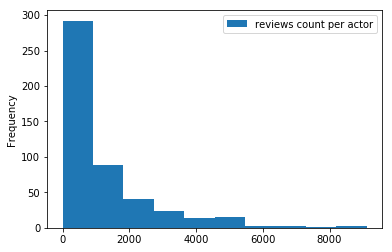

In [6]:
count_reviews.rename(columns={'reviewText':'reviews count per actor'}).plot(kind='hist')

In [7]:
filt_info = deaths[['Name','Birth Date','Death Date']].rename(columns={'Name':'actor name'})
count_Info = count_reviews.reset_index().merge(filt_info,on='actor name', how='inner')
count_Info.head()

,actor name,reviewText,Birth Date,Death Date
0,Adriana Caselotti,1,1916,1997-01-19
1,Adrienne Shelly,406,1966,2006-11-01
2,Al Martino,4,1927,2009-10-13
3,Alain Bashung,17,1947,2009-03-14
4,Alan Bates,1323,1934,2003-12-27


In [8]:
def clear_date(df, date_name):
    dout = df.drop(date_name,axis=1)
    dout[date_name] = pd.to_datetime(df[date_name]).map(lambda x: x.year)
    return dout

count_clear = clear_date(count_Info,'Death Date')
#count_clear = clear_date(count_clear_death,'Death Date')   
count_clear.head()

,actor name,reviewText,Birth Date,Death Date
0,Adriana Caselotti,1,1916,1997
1,Adrienne Shelly,406,1966,2006
2,Al Martino,4,1927,2009
3,Alain Bashung,17,1947,2009
4,Alan Bates,1323,1934,2003


In [9]:
count_clear = count_clear.copy()

def compute_age(birth, death):
    age = []
    for idx in range(0,len(birth)):
        age.append(death[idx]-birth[idx])
    return age

count_clear['Age'] = compute_age(np.array(count_clear['Birth Date']), np.array(count_clear['Death Date']))

In [10]:
filteredCounts = count_clear[count_clear['reviewText'] > 50]
filteredCounts.set_index('actor name').head()

,reviewText,Birth Date,Death Date,Age
actor name,,,,
Adrienne Shelly,406,1966,2006,40
Alan Bates,1323,1934,2003,69
Alan North,533,1920,2000,80
Alec Guinness,5296,1914,2000,86
Alida Valli,828,1921,2006,85


In [11]:
filteredAges = count_clear[count_clear['Age'] < 80]
filteredAges.set_index('actor name').head()

,reviewText,Birth Date,Death Date,Age
actor name,,,,
Adrienne Shelly,406,1966,2006,40
Alain Bashung,17,1947,2009,62
Alan Bates,1323,1934,2003,69
Alvy Moore,572,1921,1997,76
Amrish Puri,367,1932,2005,73


In [12]:
filteredDates = filteredAges[filteredAges['Death Date'] > 2007]
filteredDates.set_index('actor name').head()

,reviewText,Birth Date,Death Date,Age
actor name,,,,
Alain Bashung,17,1947,2009,62
Andy Whitfield,112,1971,2011,40
Anthony Minghella,48,1954,2008,54
Arik Einstein,1,1939,2013,74
Bernadette Lafont,88,1938,2013,75


In [13]:
filter_reviews = sample_movies_actors.set_index('actor name')
counting_mentions = []
for idx, name in enumerate(count_clear.set_index('actor name').index):
    count = 0
    if pd.Series(filter_reviews['reviewText'].get_value(name)).str.contains(name).any(): count+=1
    counting_mentions.append(count)
    
    if idx%100 == 0 : print('Current iteration: {}'.format(idx))


Current iteration: 0


/Users/marcadentsandra/miniconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


Current iteration: 100
Current iteration: 200
Current iteration: 300
Current iteration: 400


In [14]:
count_clear2= count_clear.copy()
count_clear2['isReviewed'] = counting_mentions
count_clear2[count_clear2['isReviewed']==1].shape, count_clear.shape

((428, 6), (483, 5))

### Build data

In [15]:
def create_temp_time():
    template_time = pd.to_datetime(['199'+str(i) for i in range(6,10)]+
                ['200'+str(i) for i in range(0,10)]+
                ['20'+str(i) for i in range(10,15)])
    return pd.DataFrame(template_time.year,columns=['review year'])

In [16]:
def build_data(df, name, template_years):
    
    yeardf = df[df['actor name'] == name]
    year_count = yeardf[['reviewText','ReviewTime']].groupby('ReviewTime').count()
    year_count = year_count.reset_index().rename(columns = {'ReviewTime': 'review year'})
    
    yearc_comp = (template_years.merge(year_count,on='review year',how='outer')
            .fillna(0)
            .sort_values(by='review year'))

    tot = np.sum(yearc_comp.set_index('review year'))
    density_df = (yearc_comp.set_index('review year')/tot).rename(columns={'reviewText': 'review density'})
    
    return density_df, tot

### Build example

In [17]:
review_timey = clear_date(sample_movies_actors,'ReviewTime')
review_timey.head()

,asin,reviewText,summary,actor name,death date,title,categories,salesRank,ReviewTime
0,0792840461,The Original and the best-not much to say read...,The orginal,Jack Weston,1996-05-03,The Thomas Crown Affair,"Movies & TV, Movies",{Movies & TV: 127647},2006
1,0792840461,This was a great movie Steve McQueen invented ...,Steve McQueen invented cool,Jack Weston,1996-05-03,The Thomas Crown Affair,"Movies & TV, Movies",{Movies & TV: 127647},2013
2,0792840461,"Everybody knows banks, whether in storefronts,...",Where The Dough Is,Jack Weston,1996-05-03,The Thomas Crown Affair,"Movies & TV, Movies",{Movies & TV: 127647},2014
3,0792840461,an all-time great movie and one of my favorite...,"great movie,but PLEASE avoid this copy.",Jack Weston,1996-05-03,The Thomas Crown Affair,"Movies & TV, Movies",{Movies & TV: 127647},2012
4,0792840461,Fans of a rough and tough McQueen know that th...,It's McQueen,Jack Weston,1996-05-03,The Thomas Crown Affair,"Movies & TV, Movies",{Movies & TV: 127647},2013


In [18]:
df = review_timey
name = 'Alec Guinness'
template_years = create_temp_time()

dat, tot_count = build_data(df, name, template_years)

In [19]:
death_year = count_clear.set_index('actor name')['Death Date'].get_value(name)
corr_ = list(np.array(dat.index == death_year,dtype=float)*np.array(dat['review density'], dtype = float))

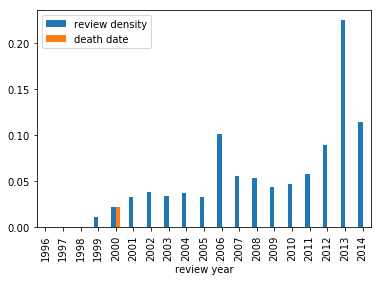

In [20]:
for_disp = dat.copy()
for_disp['death date'] = corr_
for_disp.plot(kind='bar')

### Model based analysis

In [21]:
template_years.head()

,review year
0,1996
1,1997
2,1998
3,1999
4,2000


Build Gaussian

In [22]:
def build_model(template_years, death_year, density_df, tot_count):
    
    # parameters
        len_y = len(template_years)
        half_y = round((len_y-1)/2)
        diff = (float(death_year)-float(template_years['review year'].get_value(half_y)))
        tot = tot_count
        
    # gaussian shape
        mu, sigma = diff, 0.5 # mean and standard deviation
        np.random.seed(1)
        s = np.random.normal(mu, sigma, int(tot))

        bins = np.linspace(-len_y/2,len_y/2,len_y+1)
        count, bin_edges = np.histogram(s, bins=bins)
        
    # achieve model and true serie
        true_serie = list(density_df['review density'])
        count_offset = np.mean(np.array(true_serie)*float(tot))
        model_serie = (count + count_offset)/(np.sum(count + count_offset))
        
        return  true_serie, model_serie

In [23]:
true_serie, model_serie = build_model(template_years, death_year, dat, tot_count)
len(true_serie), len(model_serie)

(19, 19)

example display

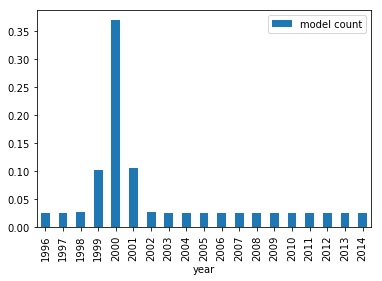

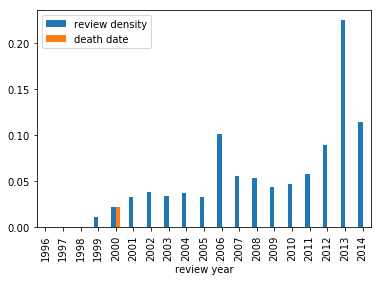

In [24]:
todisp = pd.DataFrame(model_serie,columns=['model count'])
todisp['year'] = template_years
todisp.set_index('year').plot(kind='bar')
for_disp.plot(kind='bar')

### Fit gaussian


In [25]:
def compute_corr(a,b):
    
    A = fftpack.fft(a)
    B = fftpack.fft(b)
    Ar = -A.conjugate()
    Br = -B.conjugate()
    
    delay = numpy.argmax(np.abs(fftpack.ifft(Ar*B))[0:])
    corr = numpy.max(np.abs(fftpack.ifft(Ar*B))[0:])
    
    return delay, corr, np.abs(fftpack.ifft(Ar*B))

In [26]:
delay, corr, arr = compute_corr(model_serie,true_serie)
arr

array([ 0.03743563,  0.04241832,  0.04469209,  0.04376681,  0.0443217 ,
        0.04854878,  0.06818917,  0.05748805,  0.0525634 ,  0.04944776,
        0.05059691,  0.05714288,  0.07967533,  0.11957913,  0.08289825,
        0.03518801,  0.02648778,  0.02746207,  0.03209792])

In [27]:
int(death_year) + int(delay), delay, corr

(2013, 13, 0.11957913492165377)

### Derivative based analysis

In [28]:
dff = np.diff(dat['review density'])
derivative = pd.DataFrame(np.concatenate([[0.0], dff]),columns=['temporal evolution'])
derivative['year'] = list(template_years['review year'])

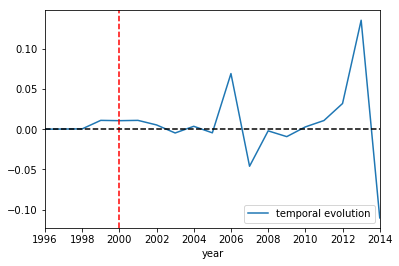

In [29]:
#derivative.plot(kind='scatter', x='year', y='temporal evolution')

ax = derivative.set_index('year').plot()
ax.axvline(x=death_year, color='red', linestyle='--')
ax.axhline(y=0.0, color='black', linestyle='--')

In [30]:
death_value = derivative.set_index('year')['temporal evolution'].get_value(death_year)
#death_value_minusone = derivative.set_index('year')['temporal evolution'].get_value(death_year+1)

In [31]:
relative_value = death_value/(np.max(derivative['temporal evolution']))
print('{}%'.format(relative_value*100))

7.810320781032079%
